In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import os

from kaggle_submit import submit_to_kaggle
from helpers import *

In [2]:
PICTURES_FOLDER = "pictures"
os.makedirs(PICTURES_FOLDER, exist_ok=True)

SLEEP_STAGES_COLORS = {
    0: "blue",
    1: "green",     
    2: "red",
    3: "black",
    4: "orange",
}

In [3]:
train_file = "kaggle_data/X_train.h5/X_train.h5"
test_file = "kaggle_data/X_test.h5/X_test.h5"

h5_train = h5py.File(train_file, mode='a')
h5_test = h5py.File(test_file, mode='a')

y_train = pd.read_csv("kaggle_data/y_train.csv", index_col=0, squeeze=True)
y_train_arr = y_train.to_numpy()

# MAKE FEATURES
from additional_features.make_features import make_all_features
make_all_features(h5_train,h5_test,overwrite=False, verbose=True)

OSError: Unable to create file (unable to open file: name = 'kaggle_data/X_train.h5/X_train.h5', errno = 17, error message = 'File exists', flags = 15, o_flags = a02)

In [97]:
IRRELEVANT_FEATURES = ['index', 'index_absolute', 'index_window',
                       'x', 'y', 'z',
                       'speed_x', 'speed_y', 'speed_z',
                       #'eeg_1', 'eeg_2','eeg_3','eeg_4','eeg_5', 'eeg_6', 'eeg_7',
                       #'pulse',
                      ]

def update_globals():
    features = [feat for feat in h5_train.keys() if feat not in IRRELEVANT_FEATURES]
    frequencies = {feat: h5_train[feat][0].size // 30 for feat in features}
    frequencies = {feat: freq if int(freq) in (10, 50) else 0 
                   for feat, freq in frequencies.items()}
    return features, frequencies
    
FEATURES, FREQUENCIES = update_globals()
print("FEATURES (sorted) =", sorted(FEATURES))
# print("FREQUENCIES =", FREQUENCIES)
print(len(FEATURES))

FEATURES (sorted) = ['accel_norm', 'accel_norm_ft_logmod', 'alpha_eeg_1_logE', 'alpha_eeg_2_logE', 'alpha_eeg_3_logE', 'alpha_eeg_4_logE', 'alpha_eeg_5_logE', 'alpha_eeg_6_logE', 'alpha_eeg_7_logE', 'beta_eeg_1_logE', 'beta_eeg_2_logE', 'beta_eeg_3_logE', 'beta_eeg_4_logE', 'beta_eeg_5_logE', 'beta_eeg_6_logE', 'beta_eeg_7_logE', 'delta_eeg_1_logE', 'delta_eeg_2_logE', 'delta_eeg_3_logE', 'delta_eeg_4_logE', 'delta_eeg_5_logE', 'delta_eeg_6_logE', 'delta_eeg_7_logE', 'eeg_1', 'eeg_1_ft_logmod', 'eeg_2', 'eeg_2_ft_logmod', 'eeg_3', 'eeg_3_ft_logmod', 'eeg_4', 'eeg_4_ft_logmod', 'eeg_5', 'eeg_5_ft_logmod', 'eeg_6', 'eeg_6_ft_logmod', 'eeg_7', 'eeg_7_ft_logmod', 'pulse', 'pulse_ft_logmod', 'pulse_max_freq', 'pulse_max_logE', 'sleep_left', 'sleep_time', 'sleep_time_relative', 'speed_norm', 'speed_norm_ft_logmod', 'theta_eeg_1_logE', 'theta_eeg_2_logE', 'theta_eeg_3_logE', 'theta_eeg_4_logE', 'theta_eeg_5_logE', 'theta_eeg_6_logE', 'theta_eeg_7_logE']
53


In [101]:
from additional_features.make_features import make_all_features

make_all_features(h5_train)


In [102]:
FEATURES, FREQUENCIES = update_globals()

In [103]:
#def ensure_integrity(h5_file):
#    keys = list(h5_file.keys())
#    for i, key in enumerate(keys):
#        print_bis(f'{i+1}/{len(keys)}')
#        x = h5_file[key][:]
#        assert np.sum(np.isnan(x)) == 0
#        assert np.sum(np.isinf(x)) == 0
        
#ensure_integrity(h5_train)
#ensure_integrity(h5_test)

## VISUALIZATION

In [104]:
def robust_rescale(df):
    """
    X_rescaled = (X - MED(X)) / MED(|X - MED(X)|)
    """
    med = df.median()
    med_spread = (df - df.median()).abs().median()
    # df_rescaled = (df - med) / med_spread
    return (df - med) / med_spread

def min_max_rescale(df):
    min_ = df.min()
    max_ = df.max()
    return (df - min_) / (max_ - min_)
    
def z_rescale(df): 
    mean = df.mean()
    std = df.std()
    return (df - mean) / std

def get_fig_subjects():
    fig, axes = plt.subplots(10, 3, figsize=(10, 40))
    return fig, np.ravel(axes)

def title_with_subject_id(ax, subject_id):
    ax.set_title(f'SUBJECT #{subject_id}')
    return None

def save_feature_quantiles(feature,
                           inf_qt=0.025,
                           sup_qt=0.975,
                           n_quantiles=21,
                           robust_rescaling=False,
                           overwrite=False,
                           verbose=True):
    """
    See pictures/quantile_plots
    
    Can be improved (make robust and not robust qplots simultaneously)
    """
    # Make directory if it does not exist
    qplot_dir = os.path.join(PICTURES_FOLDER, f"quantile_plots")
    os.makedirs(qplot_dir, exist_ok=True)
    # Escape if not overwrite and already done
    qplot_fname = os.path.join(qplot_dir, f'{feature}{"--rescaled" if robust_rescaling else ""}.png')
    if (not overwrite) and os.path.exists(qplot_fname):
        return None
    # Otherwise,
    subject_ids = get_subject_ids(h5_train)
    quantiles = np.linspace(inf_qt, sup_qt, n_quantiles).round(3)
    subjects_quantiles = dict()
    for cnt, sid in enumerate(subject_ids):
        if verbose:
            print_bis(f"FEATURE #{FEATURES.index(feature)} SUBJECT {cnt+1}/{len(subject_ids)} (RESCALE = {str(robust_rescaling)})")
        # Robust representation of the signal
        signal = get_subject_feature_signals(h5_train, sid, feature, frequencies_dict=FREQUENCIES, as_timeseries=False)
        size = signal[0].size
        signal = pd.Series(np.concatenate(signal))
        if robust_rescaling:
            signal = robust_rescale(signal)
        # Behaviour by sleep stage
        sleep_stages = get_subject_sleep_stage(sid, h5_train, y_train).values
        signal_by_stage = signal.groupby(np.repeat(sleep_stages, size))
        subjects_quantiles[sid] = signal_by_stage.quantile(quantiles).unstack(0)
        
    fig, axes = get_fig_subjects()
    for ax, sid in zip(axes, subject_ids):
        subjects_quantiles[sid].plot(ax=ax)#, color=SLEEP_STAGES_COLORS)
        title_with_subject_id(ax, sid)
    plt.savefig(qplot_fname)
    plt.close(fig)
    return subjects_quantiles


# TO WRITE QUANTILE PLOTS IN pictures/quantile_plots
#for i, feat in enumerate(FEATURES):
    # print_ter(f"========= FEATURE {i+1}/{len(FEATURES)} =========")
#    save_feature_quantiles(feat, robust_rescaling=False, overwrite=False, verbose=True)
#    save_feature_quantiles(feat, robust_rescaling=True, overwrite=False, verbose=True)


In [105]:
def get_proba_transition(subject_id=None):
    if subject_id:
        start, end = get_subject_boundaries(h5_train, subject_id, ready_to_use=False)
        y = y_train.loc[start:end]
    else: # all subjects
        y = y_train.loc[:]
    transition_df = pd.DataFrame(data={"stage": y, "stage_after": y.shift(-1)})
    transition_df = transition_df.iloc[:-1] # NaN
    transition_df = transition_df.astype(int)
    counts = transition_df.groupby(["stage", "stage_after"]).size()
    counts = counts.unstack(1, fill_value=0)
    probas = counts.div(counts.sum(axis=1), axis=0)
    probas = probas.reindex(range(0, 5), axis=0, fill_value=0)
    probas = probas.reindex(range(0, 5), axis=1, fill_value=0)
    return probas

transition_plots_dir = os.path.join(PICTURES_FOLDER, "transition_plots")
os.makedirs(transition_plots_dir, exist_ok=True)

def save_transition_plots_by_subject(overwrite=False, verbose=True):
    fpath = os.path.join(transition_plots_dir, "transition_matrix_by_subject.png")
    if (not overwrite) and os.path.exists(fpath):
        return None
    subject_ids = get_subject_ids(h5_train)
    fig, axes = get_fig_subjects()
    for ax, sid in zip(axes, subject_ids):
        if verbose:
            print_bis(f"SUBJECT #{sid}")
        probas = get_proba_transition(subject_id=sid)
        sns.heatmap(probas, ax=ax, vmin=0, vmax=1, annot=True)
        title_with_subject_id(ax, sid)
    fig.tight_layout()
    fig.savefig(fpath)
    plt.close(fig)    
    return None

def save_transition_plot_global(overwrite=False):
    fpath = os.path.join(transition_plots_dir, "transition_matrix_global.png")
    if (not overwrite) and os.path.exists(fpath):
        return None
    proba_global = get_proba_transition()
    fig, ax = plt.subplots()
    sns.heatmap(proba_global, ax=ax, vmin=0, vmax=1, annot=True)
    fig.savefig(fpath)
    plt.close(fig)
    return None
    
save_transition_plots_by_subject(overwrite=False)
save_transition_plot_global(overwrite=False)

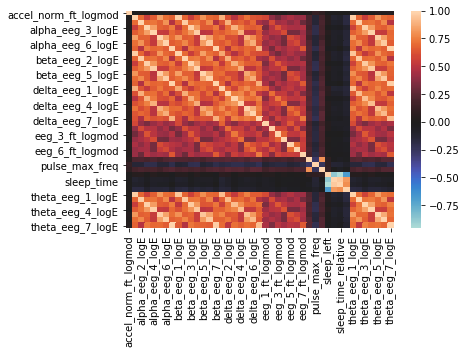

In [106]:
log_energies = [feature for feature, freq in FREQUENCIES.items() if freq == 0]
log_energies_df = pd.DataFrame({le: h5_train[le][:][:, 0] for le in log_energies})
sns.heatmap(log_energies_df.corr(), center=0)
plt.show()

In [107]:
sleep_stages_frequencies = y_train.groupby(y_train.values).count()
sleep_stages_frequencies

0    3511
1    1671
2    9449
3    5224
4    4833
Name: sleep_stage, dtype: int64

### 1. RANDOM FOREST

In [108]:
# Features are of 3 kinds

TIME_FEATURES = ['accel_norm', 'eeg_1', 'eeg_2', 'eeg_3', 'eeg_4', 'eeg_5', 'eeg_6', 'eeg_7', 'pulse', 'speed_norm']
SPECTRAL_FEATURES = [f"{time_feat}_ft_logmod" for time_feat in TIME_FEATURES]
MONO_FEATURES = [feat for feat in FEATURES if h5_train[feat][0].shape[0] == 1]

assert set(MONO_FEATURES).union(set(TIME_FEATURES)).union(set(SPECTRAL_FEATURES)) ==  set(FEATURES) 


In [109]:
# Quantiles 

LOWER_TAIL_QUANTILES = [0.01, 0.025, 0.05]
DECILES = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
UPPER_TAIL_QUANTILES = [0.95, 0.975, 0.99]

QUANTILES = LOWER_TAIL_QUANTILES + DECILES + UPPER_TAIL_QUANTILES
TAIL_QUANTILES = LOWER_TAIL_QUANTILES + UPPER_TAIL_QUANTILES


In [110]:
# Helper to create input array

# See pywavelets [https://pywavelets.readthedocs.io/en/latest/] for wavelet transform

# Extreme values of features have been used --> extreme quantiles are a good idea

# It is said in the study that there is a need for large samples to have correct resolution in frequency
#    ---> make chunks of 30s windows ??


def get_distribution_quantiles(arr, quantiles, **kwargs):
    return np.quantile(arr, q=quantiles, axis=1, **kwargs).T


def get_distribution_characteristics(arr, truncate_dist=False):
    """
    mean, variance, skewness, kurtosis
    """
    if truncate_dist:
        inf = get_distribution_quantiles(arr, 0.005, keepdims=True)
        sup = get_distribution_quantiles(arr, 0.995, keepdims=True)
        return get_distribution_quantiles(np.clip(arr, inf, sup), truncate_dist=False)
    res = np.empty(shape=(arr.shape[0], 4))
    res[:, 0] = np.mean(arr, axis=1, keepdims=False) # mean [order 1]
    res[:, 1] = np.mean((arr - res[:, [0]]) ** 2, axis=1, keepdims=False) # variance [order 2]
    z_var = ( arr - res[:, [0]] ) / res[:, [1]] 
    res[:, 2] = np.mean(z_var ** 3, axis=1, keepdims=False) # skewness [order 3]
    res[:, 3] = np.mean(z_var ** 4, axis=1, keepdims=False) # kurtosis [order 4]
    return res


def _make_input_multidimensional_feature_chunk(sequences, quantiles=QUANTILES, dist_char=True, truncate_dist=False):
    n_samples = sequences.shape[0]
    n_cols = len(quantiles) * int(len(quantiles) > 0) + 4 * int(dist_char)
    assert n_cols > 0
    res = np.empty(shape=(n_samples, n_cols))
    res[:, :len(quantiles)] = get_distribution_quantiles(sequences, quantiles)
    if dist_char:
        res[:, -4:] = get_distribution_characteristics(sequences, truncate_dist=truncate_dist)
    return res
        

def make_input_multidimensional_feature(h5_file, 
                                        feature, 
                                        quantiles=QUANTILES, 
                                        dist_char=True,
                                        truncate_dist=False,
                                        n_chunks=100):
    n_cols = len(quantiles) * int(len(quantiles) > 0) + 4 * int(dist_char)
    feature_array = np.empty(shape=(h5_file[feature].shape[0], n_cols))
    columns = [(feature, str(q)) for q in quantiles] + [(feature, mom) for mom in range(1,5) if dist_char]
    
    for i, j in chunks_iterator(n_chunks, h5_file[feature].shape[0]):
        feature_array[i:j, :] = _make_input_multidimensional_feature_chunk(
            h5_file[feature][i:j], quantiles, dist_char, truncate_dist)
        
    return feature_array, columns


### Rescaling
from sklearn.preprocessing import StandardScaler 
# already robust on not logE features because we take quantiles
# --> StandardScaler 

def make_input(h5_file, features=FEATURES, quantiles=QUANTILES, dist_char=True, truncate_dist=False, rescale=True):
    n_mono = sum([feat in MONO_FEATURES for feat in features])
    n_cols_multi = len(quantiles) + 4 * int(dist_char)
    n_cols = n_mono + n_cols_multi * (len(features) - n_mono)
    input_arr = np.empty(shape=(h5_file["index"].shape[0], n_cols))
    i = 0
    columns = list()
    for cnt, feat in enumerate(features):
        print_bis(f"Feature #{cnt}/{len(features)}")
        if feat in MONO_FEATURES:
            input_arr[:, [i]] = h5_file[feat][:]
            columns = columns + [(feat, "")]
            i += 1
        else:
            input_arr[:, i:i+n_cols_multi], cols = make_input_multidimensional_feature(
                h5_file, feat, quantiles, dist_char, truncate_dist)
            columns = columns + cols
            i += n_cols_multi
    if rescale:
        ids = get_subject_ids(h5_file)
        for id in ids:
            indices = subjects_ids_to_indexers(h5_file, [id], as_indices=True, as_boolean_array=False)
            z_scaler = StandardScaler()
            input_arr[indices,:] = z_scaler.fit_transform(input_arr[indices,:])            
    return pd.DataFrame(input_arr, columns=pd.MultiIndex.from_tuples(columns))







In [111]:
# SPLIT TRAIN / CROSS VALIDATION

def split_train_validation_subject_ids(train_perc, seed=None):
    np.random.seed(seed)
    subjects_ids = get_subject_ids(h5_train)
    shuffled_ids = np.random.permutation(subjects_ids)
    N_train = int(np.round(train_perc * len(shuffled_ids)))
    train_ids, validation_ids = shuffled_ids[:N_train], shuffled_ids[N_train:]
    return sorted(train_ids), sorted(validation_ids)

def subjects_ids_to_indexers(h5_file, subjects_ids, as_indices=False, as_boolean_array=False):
    if as_indices == as_boolean_array:
        raise NameError('Choose between `indices` and `boolean array` representations')
    if as_indices:
        boundaries = [get_subject_boundaries(h5_file, sid, ready_to_use=False) for sid in subjects_ids]
        return sum(map(lambda bounds: list(range(bounds[0], bounds[1]+1)), boundaries), list())
    if as_boolean_array:
        boolean_indexer = np.zeros(shape=(h5_file[FEATURES[0]].shape[0],), dtype=bool)
        for sid in subjects_ids:
            boolean_indexer[get_subject_boundaries(h5_file, sid, ready_to_use=True)] = True
        return boolean_indexer
        
    
def split_train_validation(X_train, 
                           train_subjects_ids=None, # ids for train
                           train_perc=None,
                           seed=None):
    if (train_subjects_ids is None) and (train_perc is None):
        raise NameError("Either `subjects_ids` or `train_perc` must be provided")
    if train_perc is not None:
        train_subjects_ids, _ = split_train_validation_subject_ids(train_perc, seed)
        return split_train_validation(X_train, train_subjects_ids=train_subjects_ids)
    
    train_selector = subjects_ids_to_indexers(h5_train, train_subjects_ids, as_boolean_array=True)
    X_train_train, y_train_train = X_train[train_selector], y_train.values[train_selector]
    X_train_val, y_train_val = X_train[~train_selector], y_train.values[~train_selector]
    
    return X_train_train, y_train_train, X_train_val, y_train_val

In [112]:
import time
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import fbeta_score

def get_eta_repr(elapsed, iteration, total_iterations):
    if iteration == 0:
        return "?"
    else:
        eta = (elapsed / iteration) * (total_iterations - iteration)
        return str(np.round(eta, 2)) + "s"
    
    
def train_on_grid(model_blueprint, params_grid, X, y):
    # Random shuffling of parameters for better ETA
    shuffled_ix = np.random.permutation(range(len(params_grid))) # for better ETA
    
    models = [None for _ in range(len(params_grid))] 
    elapsed_time = 0
    time_start = time.time()

    for i, ix in enumerate(shuffled_ix):
        print_bis(f"Training Model #{i+1}/{len(params_grid)} " +\
                  f"[ETA: {get_eta_repr(time.time() - time_start, i, len(params_grid))}]")
        model = model_blueprint(**params_grid[ix])
        model.fit(X, y)
                
        models[ix] = model
        
    return models

In [113]:
def custom_score(y_pred, y_true):
    return fbeta_score(y_pred=y_pred,
                       y_true=y_true,
                       labels=[0, 1, 2, 3, 4],
                       average="weighted",
                       beta=1)

def get_models_custom_scoring(models, X_train_train, y_train_train, X_train_val, y_train_val):
    scores = list()
    time_start = time.time()
    
    for i, model in enumerate(models):
        eta = get_eta_repr(time.time() - time_start, i, len(models))
        print_bis(f"Scoring Model #{i+1}/{len(models)} [ETA: {eta}]")
        
        y_train_pred = model.predict(X_train_train)
        y_val_pred = model.predict(X_train_val)
        model_scores = {
            "training_score": custom_score(y_train_pred, y_train_train),
            "validation_score": custom_score(y_val_pred, y_train_val),
        }
        
        
        scores.append(model_scores)
    return scores


In [114]:
def get_best_model(models, models_params, models_scores, criterion="validation_score"):
    ix_best_score = np.argmax([s[criterion] for s in models_scores])
    best_model = models[ix_best_score]
    best_model_params = models_params[ix_best_score]
    best_model_score = models_scores[ix_best_score]
    return best_model, best_model_params, best_model_score

def sort_models(models, models_params, models_scores, criterion="validation_score"):
    return sorted(zip(models, models_params, models_scores), key=lambda x: x[2][criterion])



In [115]:
# SAVE MODEL

from joblib import dump, load
ARCHIVES_FOLDER = "models_archives"
if not os.path.exists(ARCHIVES_FOLDER):
    os.makedirs(ARCHIVES_FOLDER)

def save_model(model, name):
    fpath = os.path.join(ARCHIVES_FOLDER, f"{name}.joblib")
    dump(model, fpath)
    print(f"New model saved at {fpath}")
    return fpath
    
    
def load_model(name):
    if not name.startswith(ARCHIVES_FOLDER):
        name = os.path.join(ARCHIVES_FOLDER, name)
    if not name.endswith(".joblib"):
        name = f"{name}.joblib"
    model = load(name)
    return model

LEADERBOARD_FILE = "leaderboard.txt"
if not os.path.exists(LEADERBOARD_FILE):
    with open(LEADERBOARD_FILE, 'a') as leaderboard:
        leaderboard.write(";;;".join(['path', 'training_score', 'validation_score', 'comments']))
    
def write_model_to_leaderboard(model, model_name, train_score, val_score, comments=""):
    fpath = save_model(model, model_name)
    with open(LEADERBOARD_FILE, "a") as leaderboard:
        leaderboard.write("\n" + ';;;'.join([fpath, str(train_score), str(val_score), comments]))
    


In [116]:
## Use this later : sklearn.model_selection.HalvingRandomSearchCV


from sklearn.svm import SVC


def get_inputs(make_input_func, scaler, seed=None):
    X_train = make_input_func(h5_train)
    X_test = make_input_func(h5_test)

    train_ids, validation_ids = split_train_validation_subject_ids(0.7, seed=seed)
    X_train_train, y_train_train, X_train_val, y_train_val = split_train_validation(
        X_train, train_subjects_ids=train_ids)


    X_train_train = scaler.fit_transform(X_train_train)
    X_train_val = scaler.transform(X_train_val)
    X_test = scaler.transform(X_test)
    
    return X_train_train, y_train_train, X_train_val, y_train_val, X_test


def train_until_convergence(models, X, y, verbose=True):
    time_start = time.time()
    for i, model in enumerate(models):
        print_bis(f"TRAINING UNTIL CONVERGENCE : MODEL #{i+1}/{len(models)} [ETA: {get_eta_repr(time.time() - time_start, i, len(models))}")
        model.set_params(max_iter=-1)
        model.fit(X, y)
    return models
        

def svm_no_PCA_selector( ## A REFAIRE AVEC LA DEUXIEME SELECTION SUR UN AUTRE SET QUE LA CROSS VALIDATION
    make_input_func,
    scaler,
    params_grid,
    name,
    comments="",
    select=3,
    max_iter=1000,
    seed=None):
    
    params_grid_bounded = [{k: v for k, v in pg.items()} for pg in params_grid]
    for d in params_grid_bounded:
        d["max_iter"] = max_iter
    
    X_train_train, y_train_train, X_train_val, y_train_val, X_test = \
        get_inputs_svm(make_input_func, scaler, seed=seed)
   

    # Hyperparameters space exploration

    # Training
    print("-------- (PRE-)TRAINING --------")
    svm_models = train_on_grid(SVC, params_grid_bounded, X_train_train, y_train_train)

    # Scoring
    print_ter("-------- CROSS-VALIDATION --------")
    svm_scores = get_models_custom_scoring(svm_models, X_train_train, y_train_train, X_train_val, y_train_val)

    # Pre-Selecting
    print_ter("-------- SELECTION --------")
    sorted_models = sort_models(svm_models, params_grid_bounded, svm_scores, criterion="validation_score")
    candidates = sorted_models[-select:]
    candidates = [model for model, params, score in candidates]
    
    # Train until convergence
    print_ter("-------- TRAINING CANDIDATES UNTIL CONVERGENCE --------")
    candidates_at_cvg = train_until_convergence(candidates, X_train_train, y_train_train)
    
    print_ter("-------- FINDING THE BEST MODEL --------")
    scores_at_cvg = get_models_custom_scoring(
        candidates_at_cvg, X_train_train, y_train_train, X_train_val, y_train_val)
    candidates_params = [cdt.get_params() for cdt in candidates_at_cvg]
    
    best_svm, best_svm_params, best_svm_scores =\
        get_best_model(candidates_at_cvg, candidates_params, scores_at_cvg, criterion="validation_score") 
    
    write_model_to_leaderboard(best_svm,
                               name,
                               best_svm_scores["training_score"],
                               best_svm_scores["validation_score"],
                               comments=comments
                              )
    return best_svm


In [117]:
### SVM with only extreme values without PCA
from sklearn.preprocessing import StandardScaler 

CREATE_SVM_EXTREME = False

# Create input arrays
def make_input_svm_extreme(h5_file):
    return make_input(h5_file, features=FEATURES, quantiles=TAIL_QUANTILES, dist_char=False, truncate_dist=False)

svm_extreme_params_grid_rbf_and_sigmoid = ParameterGrid(
    {"kernel": ["rbf", "sigmoid"],
     "C": [0.01, 0.1, 1, 10, 100],
     "gamma": ["auto"]
    }
)

svm_extreme_params_grid_polynomial = ParameterGrid(
    {"kernel": ["poly"],
     "C": [0.1, 1, 10],
     "degree": [1, 2, 3, 4] #if max_iter != -1
    })

svm_extreme_params_grid = list(svm_extreme_params_grid_rbf_and_sigmoid) + list(svm_extreme_params_grid_polynomial)

if CREATE_SVM_EXTREME:
   
    svm_no_PCA_selector(
        make_input_func=make_input_svm_extreme,
        params_grid=svm_extreme_params_grid,
        scaler=StandardScaler(),
        name='svm_extreme_selected_100',
        comments="tailing quantiles; no distribution chars; all features; no PCA; seed=101",
        select=5,
        max_iter=100,
        seed=101)
    
best_svm_extreme = load_model('svm_extreme_no_PCA')

FileNotFoundError: [Errno 2] No such file or directory: 'models_archives/svm_extreme_no_PCA.joblib'

In [118]:
### SVM with only extreme values without PCA
CREATE_SVM_CENTRAL = False

# Create input arrays
def make_input_svm_central(h5_file):
    return make_input(h5_file, features=FEATURES, quantiles=list(), dist_char=True, truncate_dist=True)

svm_central_grid_1 = ParameterGrid(
    {"kernel": ["rbf", "sigmoid"],
     "C": [0.01, 0.1, 1, 10, 100],
     "gamma": ["auto", "scale"],
    }
)


svm_central_grid_2 = ParameterGrid(
    {"kernel": ["poly"],
     "C": [0.1, 1, 10],
     "degree": [1, 2, 3, 4] #if max_iter != -1
    })

svm_central_grid = list(svm_central_grid_1) + list(svm_central_grid_2)

if CREATE_SVM_CENTRAL:
    best_svm_central = \
        svm_no_PCA_selector(
            make_input_func=make_input_svm_central,
            params_grid=svm_central_grid,
            scaler=StandardScaler(),
            name='svm_central_selected_100',
            comments="no quantiles; dist chars with truncation; all features; no PCA; seed=101",
            select=5, 
            max_iter=100,
            seed=101
        )
    
best_svm_central = load_model('svm_central_selected_100')
    

FileNotFoundError: [Errno 2] No such file or directory: 'models_archives/svm_central_selected_100.joblib'

In [24]:
### SVM with only extreme values without PCA
CREATE_SVM_GLOUTON = False

# Create input arrays
def make_input_svm_glouton(h5_file):
    return make_input(h5_file, features=FEATURES, quantiles=TAIL_QUANTILES, dist_char=True, truncate_dist=True)

svm_glouton_grid_1 = ParameterGrid(
    {"kernel": ["rbf", "sigmoid"],
     "C": [0.01, 0.1, 1, 10, 100],
     "gamma": ["auto", "scale"],
    }
)


svm_glouton_grid_2 = ParameterGrid(
    {"kernel": ["poly"],
     "C": [0.01, 0.1, 1, 10, 100],
     "degree": [1, 2, 3, 4] #if max_iter != -1
    })

svm_glouton_grid = list(svm_glouton_grid_1) + list(svm_glouton_grid_2)

if CREATE_SVM_GLOUTON:
    best_svm_glouton = \
        svm_no_PCA_selector(
            make_input_func=make_input_svm_glouton,
            params_grid=svm_glouton_grid,
            scaler=StandardScaler(),
            name='svm_glouton_selected_1000',
            comments="tail quantiles; dist chars with truncation; all features; no PCA; seed=101",
            select=5, 
            max_iter=1000,
            seed=101
        )
    
# best_svm_glouton = load_model('svm_glouton_selected_100')
    



-------- (PRE-)TRAINING --------


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)



-------- CROSS-VALIDATION --------
Scoring Model #32/32 [ETA: 37.54s]K
-------- SELECTION --------

-------- TRAINING CANDIDATES UNTIL CONVERGENCE --------
TRAINING UNTIL CONVERGENCE : MODEL #5/5 [ETA: 45.98sK
-------- FINDING THE BEST MODEL --------
New model saved at models_archives/svm_glouton_selected_1000.joblib


In [119]:
# svm_central = load_model("svm_central_selected_100.joblib")
from sklearn.ensemble import RandomForestClassifier

def make_input_rf(h5_file):
    return make_input(h5_file, features=FEATURES, quantiles=QUANTILES, dist_char=True, truncate_dist=True)


rf = RandomForestClassifier()

X_train_train, y_train_train, X_train_val, y_train_val, X_test = \
    get_inputs_svm(make_input_rf, StandardScaler(), seed=101)

rf.fit(X_train_train, y_train_train)
y_rf = rf.predict(X_test)


# y_pred = svm_central.predict(X_test)
# submit_to_kaggle(y_rf, h5_test, fname="soumission_rf_noob.csv", msg="")

NameError: name 'get_inputs_svm' is not defined

tuple

In [30]:
# submit_to_kaggle(y_rf, h5_test, fname="soumission_rf_noob.csv", msg="")

New submission file at submissions/soumission_rf_noob.csv


In [120]:
# make input for SVM
LOG_ENERGY_FEATURES = [feature for feature in FEATURES if feature.endswith("logE") and "eeg" in feature]

MODEL_FEATURES = [*LOG_ENERGY_FEATURES, "pulse_max_freq", "pulse_max_logE", "speed_norm", "accel_norm"]

X_train = make_input(h5_train, features=SVM_FEATURES, quantiles=QUANTILES_TAIL_CAPTURE)
X_test = make_input(h5_test, features=SVM_FEATURES, quantiles=QUANTILES_TAIL_CAPTURE)

train_ids, validation_ids = split_train_validation_subject_ids(0.7, seed=101)
X_train_train, y_train_train, X_train_val, y_train_val = split_train_validation(X_train, train_subjects_ids=train_ids)

### PCA on log_energy features
from sklearn.decomposition import PCA

pca_logE = PCA(0.9)
pca_logE.fit(X_train_train[:, :len(LOG_ENERGY_FEATURES)])

def apply_pca(X, pca, copy=True):
    if copy:
        return apply_pca(X[:, :], pca, copy=False)
    X_transformed = pca.transform(X[:, :len(LOG_ENERGY_FEATURES)])
    X[:, len(LOG_ENERGY_FEATURES) - pca.n_components_ : len(LOG_ENERGY_FEATURES)] = X_transformed
    X = X[:, len(LOG_ENERGY_FEATURES) - pca.n_components_ :]
    return X

X_train_train = apply_pca(X_train_train, pca_logE)
X_train_val = apply_pca(X_train_val, pca_logE)
X_test = apply_pca(X_test, pca_logE)

### Rescaling
#from sklearn.preprocessing import StandardScaler 
# already robust on not logE features because we take quantiles
# --> StandardScaler 

#z_scaler = StandardScaler()

#X_train_train = z_scaler.fit_transform(X_train_train)
#X_train_val = z_scaler.transform(X_train_val)
#X_test = z_scaler.transform(X_test)



TypeError: 'numpy.int64' object is not iterable

In [ ]:
### SVC Models
from sklearn.svm import SVC

svm_params_grid_rbf_and_sigmoid = ParameterGrid(
    {"kernel": ["rbf", "sigmoid"],
     "C": [0.1, 1, 10],
     "gamma": ["scale", "auto"]
    })

svm_params_grid_poly = ParameterGrid(
    {"kernel": ["poly"],
     "C": [0.1, 1, 10],
     "degree": [3, 10] #if max_iter != -1
    })
 
svm_params_grid = list(svm_params_grid_rbf_and_sigmoid) + list(svm_params_grid_poly)

svm_models = train_on_grid(SVC, svm_params_grid, X_train_train, y_train_train)

In [86]:
svm_scores = get_models_custom_scoring(svm_models, X_train_train, y_train_train, X_train_val, y_train_val)
svm_scores

[{'train_macro': 0.34906001481735155,
  'train_micro': 0.5051310682192801,
  'validation_macro': 0.2763904479917661,
  'validation_micro': 0.4335997279374256},
 {'train_macro': 0.2614320675993827,
  'train_micro': 0.369011538257032,
  'validation_macro': 0.25364166732316773,
  'validation_micro': 0.3479000170039109},
 {'train_macro': 0.34906001481735155,
  'train_micro': 0.5051310682192801,
  'validation_macro': 0.2763904479917661,
  'validation_micro': 0.4335997279374256},
 {'train_macro': 0.2614320675993827,
  'train_micro': 0.369011538257032,
  'validation_macro': 0.25364166732316773,
  'validation_micro': 0.3479000170039109},
 {'train_macro': 0.4425298480449335,
  'train_micro': 0.5605891423406179,
  'validation_macro': 0.3625099634566772,
  'validation_micro': 0.4762795442951879},
 {'train_macro': 0.2701379314099138,
  'train_micro': 0.352634657308449,
  'validation_macro': 0.2471371194507579,
  'validation_micro': 0.3239245026356062},
 {'train_macro': 0.4425298480449335,
  'train

In [87]:
best_svm_model, best_svm_params, best_svm_scores = \
    get_best_model(svm_models, svm_params_grid, svm_scores, criterion="validation_weighted")
best_svm_scores

NameError: name 'scores' is not defined

In [26]:
from sklearn.ensemble import RandomForestClassifier


random_forest_params = {
    "n_estimators": [10, 30, 100, 150],
    "max_depth": [3, 10, 30, 100],
    "min_samples_leaf": [1, 10, 100]}

random_forest_params_grid = list(ParameterGrid(random_forest_params))

random_forest_models = train_on_grid(
    RandomForestClassifier, 
    random_forest_params_grid,
    X_train_train,
    y_train_train
)

In [27]:
random_forest_scores = get_models_custom_scoring(
    random_forest_models,
    X_train_train,
    y_train_train,
    X_train_val,
    y_train_val
)
                   
random_forest_results = pd.concat([pd.DataFrame(random_forest_params_grid), pd.DataFrame(random_forest_scores)],
                                  keys=['params', 'scores'],
                                  axis=1)

random_forest_results = random_forest_results.sort_values(
    by=[('scores', 'validation_weighted')], 
    ascending=False
)
random_forest_results


params                                       scores                    
   max_depth min_samples_leaf n_estimators train_weighted validation_weighted
33        30              100           30       0.643324            0.463518
44       100              100           10       0.632910            0.463180
47       100              100          150       0.645184            0.459087
32        30              100           10       0.636848            0.458153
35        30              100          150       0.642077            0.458108
46       100              100          100       0.650043            0.455831
45       100              100           30       0.644333            0.452113
13        10                1           30       0.776089            0.451573
22        10              100          100       0.625828            0.448405
18        10               10          100       0.730110            0.448180
20        10              100           10       0.605076            0.446696
34        30              100          100       0.642172            0.446280
15        10                1          150       0.777016            0.445642
17        10               10           30       0.733018            0.445101
14        10                1          100       0.773608            0.443539
19        10               10          150       0.736907            0.442927
29        30               10           30       0.861906            0.440397
23        10              100          150       0.620544            0.439826
21        10              100           30       0.627548            0.435553
40       100               10           10       0.848140            0.431173
31        30               10          150       0.866251            0.428421
30        30               10          100       0.867118            0.428166
16        10               10           10       0.715539            0.426722
42       100               10          100       0.865487            0.426040
12        10                1           10       0.771079            0.425536
43       100               10          150       0.867630            0.425310
26        30                1          100       0.999947            0.421711
38       100                1          100       1.000000            0.421072
27        30                1          150       1.000000            0.419689
41       100               10           30       0.861385            0.418482
28        30               10           10       0.852121            0.417446
39       100                1          150       1.000000            0.417376
24        30                1           10       0.993775            0.409579
37       100                1           30       0.999362            0.407556
25        30                1           30       0.999415            0.406882
5          3               10           30       0.430079            0.398412
10         3              100          100       0.426527            0.397599
8          3              100           10       0.423867            0.396972
11         3              100          150       0.423755            0.396174
6          3               10          100       0.427860            0.396089
9          3              100           30       0.424250            0.395990
3          3                1          150       0.427091            0.395918
7          3               10          150       0.428306            0.395441
36       100                1           10       0.993130            0.394673
1          3                1           30       0.422541            0.393717
2          3                1          100       0.421754            0.391809
0          3                1           10       0.415593            0.376588
4          3               10           10       0.381092            0.347265

In [28]:
best_random_forest_model, _, _ = get_best_model(random_forest_models, random_forest_params_grid, random_forest_scores)
    
random_forest_prediction = best_random_forest_model.predict(X_test)


In [29]:
from kaggle_submit import submit_to_kaggle

# submit_to_kaggle(random_forest_prediction, h5_test, fname="submission_rf.csv", msg="rf")

New submission file at submission_rf.csv


In [24]:
h5_train.close()
h5_test.close()